<h2><b>The Fermi-Hubbard Model: Introduction & Encodings</b></h2>
<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

<h3><u>1. Overview</u></h3>

This notebook introduces the Fermi-Hubbard model and demonstrates how `pyLIQTR` can  encode of this problem for use with quantum algorithms.  Our reference problem will be a two-dimensional, single-band instance, which allows us to leverage resource-optimized encodings for fermionic Hamiltonians. 

<hr></hr>

<h3><u>2. Background</u></h3>


The Fermi-Hubbard (FH) model is essentially a minimal treatment of electronic structure for periodic systems. While reductionistic, this model is believed to capture much of the physics underlying strong correlation. In this case, the electronic properties of a material are described by specifying one or more orbitals on each lattice site. Adjacent sites are coupled using tight-binding terms, while the Coulomb interaction is reduced to an on-site contact interaction between different spin channels.  The resulting Hamiltonian assumes a straightforward form:

\begin{equation}
H = \underbrace{-J\sum_{\langle p,q \rangle,\sigma} \left[c^\dagger_{p,\sigma} c_{q,\sigma} + c^\dagger_{q,\sigma} c_{p,\sigma}\right]}_{\text{Hopping}} + \underbrace{U \sum_{\langle p \rangle} n_{p,\uparrow} n_{p,\downarrow}}_{\text{Density Interaction}}.
\end{equation}

We have written this example for a single band, e.g., with one orbital per lattice site.  The first term in this Hamiltonian corresponds to a standard tight-binding model.  In the absence of interactions ($U = 0$) this  describes the propagation of fermions between sites at a rate determined by $J$.  The second term delivers a notorious degree of complexity - here, the parameter $U$ specifies the strength of many-body interactions.  These interations modulate the effective hopping rate while tuning on-site carrier and spin densities. Our notation labels the lattice sites using composite indices $p,q$ and introduces $\sigma \in \{\uparrow,\downarrow\}$ to denote the spin eigenstate (we can add an orbital index to $p,q$ in more complex arrangements).  Angle brackets denote summation over nearest-neighbor pairs, while the operators $c^\dagger_{p,\sigma}, c_{p,\sigma}$ describe the creation or annihilation of a spin-$\sigma$ fermion on the  $p$-th site.  The  $n_{k,\sigma} = c^\dagger_{k,\sigma} c_{k,\sigma}$ are the corresponding number operators.

While approximate, the Fermi-Hubbard Hamiltonian is believed to capture many important aspects of electronic correlation (such as the competition between electronic and magnetic orders).  Analytical and numerical results both suggest an intricate phase diagram for this model.  However, many theoretically efforts have been limited by inherent mathematical complexities or the exponential overhead required for precise numerical treatments.  It is nonetheless clear that the interaction strength  $U/J$ and doping fraction have a strong effect on the degree of many-body correlations and the nature of emergent phases. Indeed, prior efforts have suggested that these might span from Mott insulating and antiferromagnetic regimes to (non)-Fermi liquid behavior and unconventional superconducting states.  Verifying these assertions will likely require methods beyond classical computation.  

<h3><u>3. Implementation</u></h3>


The FH Hamiltonian is defined in terms of Fock-space states instead of qubits.   Since there is no unique mapping between these representations, we have the freedom to adopt fermion-to-qubit mappings with distinct tradeoffs in terms of locality and complexity.  This section introduces the Jordan-Wigner transform (JWT), which is arguably the most conceptually straightforward correspondence.  



The JWT gives a mapping between spinless fermions and su(2) operations (or, equivalently, hard-core bosons).  To present this explicitly, we rewrite operators $c^\dagger,c$ for spinless fermions  in terms of spin ladder operators $\sigma_j^{\pm} = (X_j \pm \imath Y_j)/2$ so that:


\begin{align}
c_j &=  (-Z_m)^{\otimes (j-1)} \otimes \sigma^-_j \otimes I^{\otimes(N-j)}, & \hspace{30pt}
c^\dagger_j &= (-Z_m)^{\otimes (j-1)}   \otimes \sigma^+_j \otimes I^{\otimes(N-j)}.
\end{align}

 We use $Z^{\otimes N} = \bigotimes_{m=1}^N Z_m$ to denote the $N$-fold tensor product and write $I^{\otimes N}$ is the identity operator on $N$ qubits.  Some straightforward algebra gives an expression for the hopping terms in tight-binding chains,

\begin{equation}
c^\dagger_j c_k = \sigma^+_j \otimes (-Z)^{\otimes (k-j-1)} \otimes \sigma^-_k,
\end{equation}

and the fermionic number operators,

\begin{equation}
n_k = c^\dagger_k c_k = (I_k + Z_k)/2.
\end{equation}

Note that some authors switch $\sigma^-$ and $\sigma^+$ when defining the JWT, which ultimately flips $Z_K \mapsto -Z_k$ in the number operator. The expressions above capture a general rule: the "one-dimensional" arrangement of our fermionic Fock space implies that fermionic operators on non-adjacent sites will map to Pauli strings that contain an interstitial stretch of Pauli $Z$ operations.  These factors track the signs associated with fermionic  statistics.

<b>Note:</B> We will write tensor products explicitly for qubits / qubit operations from this point onward.  We will also add explicit labels (subscripts) for the qubits targeted by an operator, unless it is unambiguous from context.  As a final note, the index of a target qubit will always increase when reading a Pauli string from left-to-right.


<h4><b>3.1. Fermi-Hubbard to Spins: One-Dimension</b></h4> 

The one-dimensional FH Hamiltonian is particularly simple:

\begin{equation}
H = \underbrace{-J\sum_{k,\sigma} \left[c^\dagger_{k+1,\sigma} c_{k,\sigma} + c^\dagger_{k,\sigma} c_{k+1,\sigma}\right]}_{\text{Hopping}} + \underbrace{U \sum_k n_{k,\uparrow} n_{k,\downarrow}}_{\text{Density Interaction}}.
\end{equation}

We will rewrite this in terms of qubits using the Jordan-Wigner transformation.  Our spinful model might seem at odds with this strategy,  which delivers a correspondence for <i>spinless</i> fermions.  There is, however, a standard trick to deal with this issue.  The central idea is to recast the problem using bipartite lattices of spinless fermions:



<figure>
<center><img src="./figures/fh_1d_strings.png" width=500></img></center>
</figure>

The one-dimensional lattice (<b>a</b>) is the physical domain of FH.  This arrangement comprises $N$ spatial sites that contain both spin-up and spin-down orbitals. Hopping occurs between adjacent sites, while  the many-body interaction couples spins on the same site  through a density interaction. The mapping to spinless fermions expands the lattice into a $2N$ site chain and gives a bipartite partition into sublattices for each spin state (<b>b</b>).  Spin-up  or spin-down particles now occupy odd (green) or even lattice sites (orange), respectively.  Since hopping is restricted to a given spin channel, we must extend our nearest-neighbor coupling to next-nearest neighbors (orange and green dashed lines).  Conversely, the on-site spin density interaction is now defined between pairs of consecutive sites (designated by the blue circles).  The Jordan-Wigner strings pick up an additional Pauli $Z$ operator when traversing the chain due to an interstitial site from the opposite-spin sublattice. 


This arrangement can be stated formally,

\begin{align}
c_{k,\uparrow}   &\mapsto c_{2k - 1} &  \,\,\,\,\,\,\,  & c_{k+1,\uparrow} & \mapsto c_{2k + 1} \\
c_{k,\downarrow} &\mapsto c_{2k}     &  \,\,\,\,\,\,\,  & c_{k+1,\downarrow} & \mapsto c_{2k+2},
\end{align}

which leads to a Hamiltonian for the expanded system,

\begin{equation}
H = -J\sum_{k=1}^{N/2}  \Big[ \underbrace{c_{2k+1}^\dagger c_{2k-1} + c^\dagger_{2k-1} c_{2k+1}}_{\text{Spin-Up Hopping}} + \underbrace{c^\dagger_{2k+2} c_{2k} + c^\dagger_{2k} c_{2k+2}}_{\text{Spin-Down Hopping}} \Big] + U \sum_{k=1}^{N/2} n_{2k-1} n_{2k}.
\end{equation}

This maps directly to qubits by applying the JWT:

\begin{split}
H = \frac{J}{2}\sum_{k=1}^{N/2} [X_{2j-1} \otimes Z_{2j} \otimes X_{2j+1} + Y_{2j-1} \otimes Z_{2j} \otimes Y_{2j+1}]   \\ + \frac{J}{2}\sum_{k=1}^{N/2} [X_{2j} \otimes Z_{2j+1} \otimes X_{2j+2} + Y_{2j} \otimes Z_{2j+1} \otimes Y_{2j+2}]  \\
+ \frac{U}{4} \sum_{k=1}^N (I_{2k-1} + Z_{2k - 1}) \otimes (I_{2k} + Z_{2k}).
\end{split}

As a reminder, we include explicit tensor products for spin operators to make the string structure apparent, though padding identity operators are implicitly assumed.

<h4><b>3.2. Fermi-Hubbard to Spins: Two or More Dimensions</b></h4> 


The extension to higher dimensions follows immediately from our preceding discussion.  We will demonstrate this explicitly for  an $N_x \times N_y$  rectangular lattice, taking the $x$ spatial direction across rows and the $y$ dimension down columns.  

Once again, we double the lattice to accommodate  both spin channels.  By convention this doubles the number of sites in each row to give a  $2 N_x \times N_y$ system.  Although JWT is formally defined using a one-dimensional chain, we can map this to our lattice defining a path that zigzags back and forth between consecutive rows.  This  translates the hopping down columns into a long range coupling between every $N$-th site. This is a common tactic when dealing with lattice Hamiltonians, with regard to both quantum and  classical algorithms (e.g., certain classes of tensor networks).


<center><img src="./figures/fh_2d_mapping.png" width=850></img></center>

The extension to higher dimensions follows immediately from our preceding discussion.  We will demonstrate this explicitly for  an $N_x \times N_y$  rectangular lattice, taking the $x$ spatial direction across rows and the $y$ dimension down columns.  

Once again, we double the lattice to accommodate  both spin channels.  By convention this doubles the number of sites in each row to give a  $2 N_x \times N_y$ system.  Although JWT is formally defined using a one-dimensional chain, we can map this to our lattice defining a path that zigzags back and forth between consecutive rows.  This  translates the hopping down columns into a long range coupling between every $N$-th site. This is a common tactic when dealing with lattice Hamiltonians, with regard to both quantum and  classical algorithms (e.g., certain classes of tensor networks).


<center><img src="./figures/fh_2d_interactions.png" width=750></img></center>


The next step is to formalize this in terms of operators. To do so, we must define an indexing scheme for the expanded chain:

<center><img src="./figures/fh_2d_strings.png" width=400></img></center>


This convention partitions the FH Hamiltonian into terms for distinct classes of operators,

\begin{equation}
H = \underbrace{H_{R,\text{odd}} + H_{R,\text{even}}}_\text{Inter-row hopping} + \underbrace{H_{C,\text{odd}} + H_{C,\text{even}}}_\text{Column (intra-row) hopping} + \underbrace{H_I}_\text{Spin-spin}.
\end{equation}

Here,  the components of $H_{R,\text{odd}}$ and $H_{R,\text{even}}$ describe particle hopping along rows of odd  (spin-up) and even (spin-down) parity sublattices, while $H_{C,\text{odd}}$ and $H_{C,\text{even}}$ capture the same for long-range couplings when traversing a column. Interactions are contained in $H_I$.

The Hamiltonian terms for each row are identical to the one-dimensional bipartite model, where the constituent Pauli strings consist of next-nearest neighbor couplings in each sublattice:


\begin{align}
H_{R,\text{odd}} &= \frac{J}{2}\sum_{j,k} \Big[X_{j,2k-1} \otimes Z_{j,2k} \otimes X_{j,2k+1} + Y_{j,2k-1} \otimes Z_{j,2k} \otimes Y_{j,2k+1} \Big], \\
H_{R,\text{even}} &= \frac{J}{2}\sum_{j,k} \Big[X_{j,2k} \otimes Z_{j,2k+1} \otimes X_{j,2k+2} + Y_{j,2k} \otimes Z_{j,2k+1} \otimes Y_{j,2k+2}\Big].  
\end{align}



Hopping between successive rows (e.g., down columns) is slightly more complicated.  Since spin-up and spin-down fermions are represented on distinct sublattices, our couplings are of the form $(j,2k-1) \mapsto (j+1,2k-1)$ or $(j,2k) \mapsto (j+1,2k)$ , respectively.  This gives rise to $Z$-strings that extend from a  site in row $j$ to the corresponding site in row $(j+1)$.  Writing this explicitly for the odd (spin-up) sublattice we have,

\begin{split}
H_{C,\text{odd}} =  \frac{J (-1)^{N_x} }{2} \sum_{j,k} \Big[X_{j,2k-1} \otimes \Big(\bigotimes_{\ell = 2k}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-2} Z_{i,\ell}\Big) \otimes X_{j+1,2k-1} \\ 
+ Y_{j,2k-1} \otimes \Big(\bigotimes_{\ell = 2k}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-2} Z_{i,\ell}\Big) \otimes Y_{j+1,2k-1}\Big], \\ 
\end{split}

and similarly for the even (spin-down) sublattice,

\begin{split}
H_{C,\text{even}} =  \frac{J (-1)^{N_x} }{2} \sum_{j,k} \Big[X_{j,2k} \otimes \Big(\bigotimes_{\ell = 2k+1}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-1} Z_{i,\ell}\Big) \otimes X_{j+1,2k} \\ 
+ Y_{j,2k} \otimes \Big(\bigotimes_{\ell = 2k+1}^{N_x} Z_{i,\ell}\Big)  \otimes \Big(\bigotimes_{\ell = 1}^{2k-1} Z_{i,\ell}\Big) \otimes Y_{j+1,2k}\Big]. \\ 
\end{split}

Note that we traverse $N_x - 1$ sites between the two endpoints, giving the factor of $(-1)^{N_x}$ from our $Z$-string contributions (we get an additional sign from our definition of the Hamiltonian).  Finally, we must handle the on-site density interaction between opposite spins. Since the coupling is between adjacent sites in the chain, the expression  remains identical to the 1-$d$ case:

\begin{equation}
H_I = \frac{U}{4} \sum_{j,k} (I_{j,2k-1} + Z_{j,2k - 1}) \otimes (I_{j,2k} + Z_{j,2k}).
\end{equation}




The three-dimensional case follows immediately from two dimensions as a "stacking" of zigzag layers.


<h3><u>4. Quantum Algorithms</u></h3>

`pyLIQTR` provides an implementation of the Fermi-Hubbard model that can be used with a variety of algorithms.  We describe the use of this instance and provide demonstration code below.

In [12]:

import  numpy                  as   np
import  matplotlib.pyplot      as   plt

from    scipy.optimize               import  curve_fit
from    qualtran.cirq_interop.jupyter_tools  import  svg_circuit


## Circuit decomposition
##
from    pyLIQTR.utils.circuit_decomposition                   import   circuit_decompose_multi      

## Problem instance & Encoding items
##
from    pyLIQTR.ProblemInstances.getInstance                  import   getInstance
from    pyLIQTR.clam.lattice_definitions                      import   CubicLattice, SquareLattice, TriangularLattice
from    pyLIQTR.BlockEncodings.getEncoding                    import   getEncoding, VALID_ENCODINGS

## Resource analysis
##
from   pyLIQTR.utils.resource_analysis                        import   estimate_resources

## OpenQASM Export
##
from   pyLIQTR.utils.printing                                 import openqasm

<h4><b>4.1. Fermi-Hubard Instance</b></h4> 

The `pyLIQTR` problem instance library provides a straightforward method to generate Fermi-Hubbard Hamiltonians.  In particular, the `FermiHubbard` instance defines the Hamiltonian,

\begin{equation}
H = -J\sum_{\langle p,q \rangle,\sigma} \left[c^\dagger_{p,\sigma} c_{q,\sigma} + c^\dagger_{q,\sigma} c_{p,\sigma}\right] + U \sum_{\langle p \rangle} n_{p,\uparrow} n_{p,\downarrow},
\end{equation}

assuming a single orbital per site and nearest-neighbor coupling between lattice sites (<b>upcoming:</b> <i>nearest-neighbor couplings, anisotropies, and multiple orbitals</i>).  This can be defined on lattices of arbitrary geometry or spatial dimensionality.  For instance, we can define a model with $U/J = 4$ on a square lattice as:

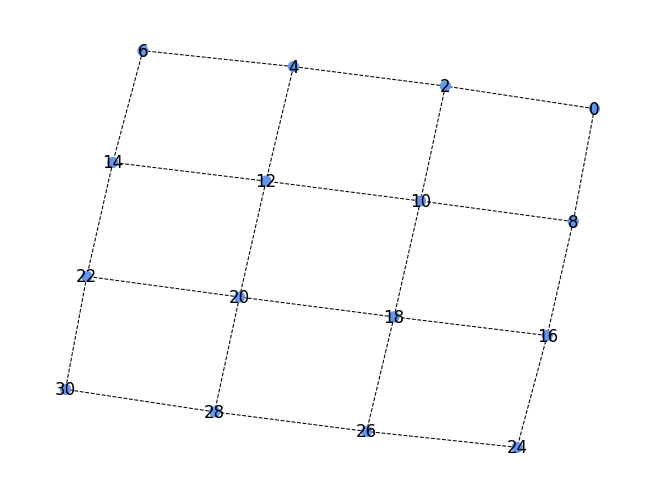

In [13]:
model  =  getInstance('FermiHubbard',shape=(4,4), J=1, U=4.0,cell=SquareLattice)
model.draw_lattice()

This draws physical lattice associated with the fermionic model.  We can render the bipartite computational lattice by requesting the display of separate spin channels:

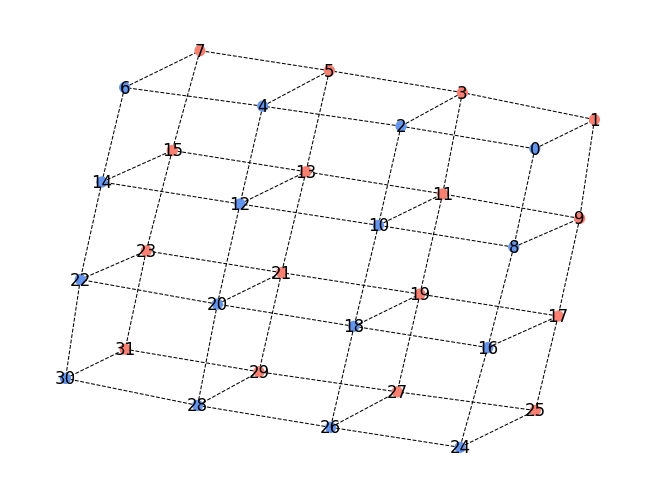

In [14]:
model  =  getInstance('FermiHubbard',shape=(4,4), J=-1, U=4.0,cell=SquareLattice)
model.draw_lattice(single_spin=False)

We can access Pauli string terms associated the Jordan-Wigner transform of this model:

In [15]:
terms = model.pauli_terms()
terms

[([0], 'Z', 0.011363636363636364),
 ([1], 'Z', 0.011363636363636364),
 ([2], 'Z', 0.011363636363636364),
 ([3], 'Z', 0.011363636363636364),
 ([4], 'Z', 0.011363636363636364),
 ([5], 'Z', 0.011363636363636364),
 ([6], 'Z', 0.011363636363636364),
 ([7], 'Z', 0.011363636363636364),
 ([8], 'Z', 0.011363636363636364),
 ([9], 'Z', 0.011363636363636364),
 ([10], 'Z', 0.011363636363636364),
 ([11], 'Z', 0.011363636363636364),
 ([12], 'Z', 0.011363636363636364),
 ([13], 'Z', 0.011363636363636364),
 ([14], 'Z', 0.011363636363636364),
 ([15], 'Z', 0.011363636363636364),
 ([16], 'Z', 0.011363636363636364),
 ([17], 'Z', 0.011363636363636364),
 ([18], 'Z', 0.011363636363636364),
 ([19], 'Z', 0.011363636363636364),
 ([20], 'Z', 0.011363636363636364),
 ([21], 'Z', 0.011363636363636364),
 ([22], 'Z', 0.011363636363636364),
 ([23], 'Z', 0.011363636363636364),
 ([24], 'Z', 0.011363636363636364),
 ([25], 'Z', 0.011363636363636364),
 ([26], 'Z', 0.011363636363636364),
 ([27], 'Z', 0.011363636363636364),
 (

as well as the normalization factor for the Hamiltonian:

In [16]:
model.alpha

88.0

We define the same model on a triangular lattice:

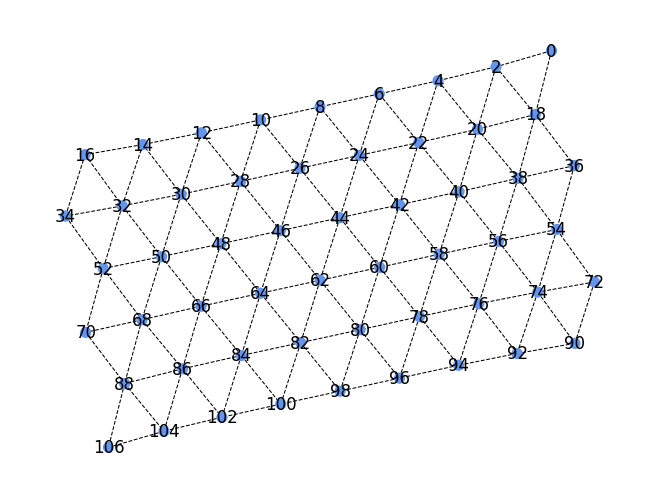

In [17]:
model  =  getInstance('FermiHubbard',shape=(3,3), J=-1, U=4.0,cell=TriangularLattice)
model.draw_lattice()

or even a cubic lattice:

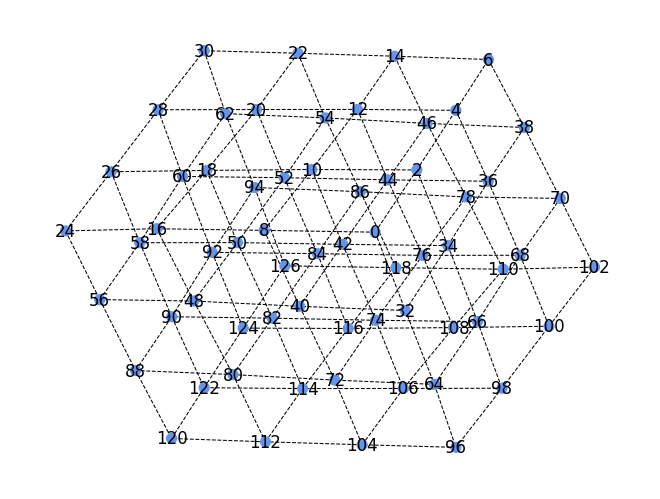

In [18]:
model  =  getInstance('FermiHubbard',shape=(4,4,4), J=-1, U=4.0,cell=CubicLattice)
model.draw_lattice()

<h4><b>4.2. Qubitized Methods</b></h4> 


The FH Hamiltonian can be used with any of our qubitized algorithms.  Access to this Hamiltonian must, however, be provided by a block encoding.  `pyLIQTR` currently provides two compatible options, both of which  operate within the Select-Prepare paradigm.  Here, we block encode an operator $\Lambda = \sum_i \alpha_i \Lambda_i$ within a unitary $U_\Lambda$ using the following circuit:

<center><img src="./figures/block_encoding_select_prepare.png" width=850></img></center>

If we define subcircuits so that the $\text{Prepare}$ oracle is $U_\text{Prep} = \sum_k \sqrt{\alpha_k}|k\rangle \langle G|$ and the $\text{Select}$ oracle is $U_\text{Select} = \sum_k | k \rangle \langle k | \otimes \Lambda_k$, we find that:

\begin{equation}
U_\text{Prep}^{-1} \cdot U_\text{Select} \cdot U_\text{Prep} = |G \rangle \langle G | \otimes \Big(\sum_k \alpha_k \Lambda_k \Big) =  |G \rangle \langle G | \otimes \Lambda.
\end{equation}


This allows us to extract $\Lambda$ conditional on measuring $| G\rangle$ in the $m$-qubit signal (or selection) register.

<h5><b>4.2.1 Block Encoding: PauliLCU</b></h5>

This elementary encoding expresses the FH Hamiltonian $H = \sum_i \alpha_i U_i$ as a linear combination of unitary operators.  In this case, the $U_i$ are given by the Pauli strings from the Jordan-Wigner transformation.  The `PauliLCU` encoding can handle any Hamiltonian, though it is less efficient than problem-specific encodings.  


In [19]:
model  =  getInstance('FermiHubbard',shape=(2,2), J=-1.0, U=4.0,cell=SquareLattice)
block_encoding = getEncoding(VALID_ENCODINGS.PauliLCU)(model)

The normalization factor for this encoding is just the 1-norm of LCU coefficients:

In [20]:
block_encoding.alpha

18.0

---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision.

We can estimate the resources for this encoding by compiling to the Clifford+$T$ basis:
    

In [21]:
resource_estimate_block  =  estimate_resources(block_encoding)
print(resource_estimate_block)

{'LogicalQubits': 13, 'T': 6712, 'Clifford': 13767}


Note that estimate resources has two keyword arguments that control $T$-synthesis.  The first is `rotation_gate_precision` (default `= 1e-10`), which specifies the maximum approximation error each rotation.  The second is `circuit_precision`, which overrides `rotation_gate_precision` if specified and sets the maximumum approximation error to `circuit_precision` / $N_\text{gates}$, where $N_\text{gates}$ is the number of rotation gates in a given circuit element.

---
#### LIQTR Like 👍 : Circuit Scheduling
---

Circuits can be 'scheduled' using the `pyLIQTR.scheduler.scheduler.schedule_circuit` function. This will provide circuit runtime, realistic qubit counts, T-depth, and more!

`schedule_circuit` takes a number of optional arguments depending on desired outputs. They are:
* `architecture_config`: an `architecture` class object specifying gate times and state factory parameters. See `scheduling_example.ipynb` for details.

* `full_profile`: default `False`. If set to `True`, function output will include T-widths and parallelism distribution data. (NOTE: T-widths and parallelism data will only be accurate if `decomp_level` is set to `'Full'`.)

* `decomp_level`: int, default 0. Levels of decomposition implemented before scheduling. If set to `0`, each operator will be decomposed to one/two-qubit gates only on its first occurance and cached for each future occurance. If set to `'Full'`, entire circuit will be decomposed to one/two-qubit gates before scheduling. 

* `context` : cirq.DecompositionContext, default is none which will result in the use of a context manager that tries to minimize the number of ancilla generated. At times, certain Qualtran Bloqs may have an error in their decomposition which results in ancilla not being properly cleared. If this happens, we recommend passing `context=cirq.DecompositionContext(cirq.SimpleQubitManager())` to resolve this issue, at the cost of an overzealous qubit allocation.

* `rotation_gate_precision`: default 5e-6. Rotations are decomposed to a given precision. This can be passed explicitly using the `rotation_gate_precision` keyword argument. If no precision argument is provided, the default value will be used. Note that higher-precision will generally increase the resource cost.

For further details on scheduler capabilities, see `Algorithms_and_Infrastructure/scheduling_example.ipynb`.

In [23]:
from pyLIQTR.scheduler.scheduler import schedule_circuit
res = schedule_circuit(block_encoding.circuit, full_profile=True, decomp_level='Full')
for r in res:
    print(f"{r} : {res[r]}")

Total time for execution : 172400
Circuit T-depth : 1035
Number of qubits used : 17
Gate profile : {'T': 1110, 'H': 2088, 'S': 54, 'CX': 310, 'Toffoli': 0, 'CZ': 54, 'Pauli (X, Y, Z)': 142, 'Measurement/Reset': 60}
Active qubit distribution : {12: 1, 1: 123, 3: 88, 2: 144, 4: 79, 5: 29, 6: 8, 9: 1, 7: 1}
T-widths : {0: 358, 1: 97, 3: 1, 2: 19}
T-proportion : {0: 358, 1.0: 31, 0.5: 41, 0.33: 29, 0.67: 4, 0.25: 6, 0.2: 4, 0.17: 1, 0.4: 1}
Clifford/T ratios : {0: (0, 0), 1: (12, 0), 2: (0, 1), 3: (0, 3), 4: (0, 1), 5: (0, 1), 6: (1, 1), 7: (1, 0), 8: (1, 0), 9: (1, 0), 10: (1, 0), 11: (1, 0), 12: (1, 0), 13: (1, 0), 14: (1, 0), 15: (1, 0), 16: (1, 0), 17: (1, 0), 18: (1, 0), 19: (1, 0), 20: (0, 1), 21: (1, 1), 22: (1, 0), 23: (2, 0), 24: (1, 0), 25: (2, 0), 26: (2, 0), 27: (2, 0), 28: (2, 0), 29: (2, 0), 30: (2, 0), 31: (0, 2), 32: (2, 2), 33: (2, 0), 34: (1, 0), 35: (3, 0), 36: (1, 0), 37: (3, 0), 38: (1, 0), 39: (1, 0), 40: (1, 0), 41: (2, 1), 42: (2, 0), 43: (2, 0), 44: (2, 0), 45: (2,

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `qualtran` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show supported levels of decompositions:

In [11]:
circuit_decompose_multi(block_encoding.circuit,1) 

selection0: ───prepare_pauli_lcu───In───────────────prepare_pauli_lcu───
               │                   │                │
selection1: ───selection───────────In───────────────selection───────────
               │                   │                │
selection2: ───selection───────────In───────────────selection───────────
               │                   │                │
selection3: ───selection───────────In───────────────selection───────────
               │                   │                │
selection4: ───selection───────────In───────────────selection^-1────────
                                   │
target0: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target1: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target2: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target3: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target4: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target5: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target6: ──────────────────────────SelectPauliLCU───────────────────────
                                   │
target7: ──────────────────────────SelectPauliLCU───────────────────────

In [12]:
circuit_decompose_multi(block_encoding.circuit,2) 

_decompose_protocol_7_c(0): ─────────────────And───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────X───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────And†───────And───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────X───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────And†────────────────
                                             │     │                                                                                                                                                                                                    │                                                                                                                              │      │   │                                                                                                                                │                                                                                                                              │      │          │     │                                                                                                                                │                                                                                                                              │      │   │                                                                                                                                │                                                                                                                              │      │
_decompose_protocol_7_c(1): ─────────────────┼─────And───@────────────────────────────────────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────@──────X───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────And†───┼───And───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────X───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────And†───┼──────────┼─────And───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────X───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────And†───┼───And───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────X───@──────────────────────────────────────────────────────────@────────────────────────────────────────────────────────@──────And†───┼───────────────────
                                             │     │     │                                                                                            │                                                                                          │          │                                                          │                                                        

In [13]:
circuit_decompose_multi(block_encoding.circuit,3) 

/Users/ar26431/miniconda3/envs/pylqt/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/ar26431/miniconda3/envs/pylqt/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


┌───────────┐                                     ┌───────────┐                                    ┌──┐                                                                                  ┌────────────┐                                                                                                                                                                    ┌──┐                                                                 ┌──┐       ┌──┐   ┌──┐                                                                                                                                                 ┌──┐                                                                                                       ┌──┐       ┌──┐   ┌──┐       ┌──┐   ┌──┐   ┌──┐                                                                                                                                                                                       ┌──┐                                                                                                       ┌──┐       ┌──┐   ┌──┐                                                                                                                                   ┌──┐                                                                                         ┌──┐       ┌──┐   ┌──┐       ┌──┐   ┌──┐       ┌──┐                           ┌─────┐                                                                                                                                                                                            ┌──┐                                                                                         ┌──┐       ┌──┐   ┌──┐                                                                                                                               ┌──┐                                                                                         ┌──┐       ┌──┐   ┌──┐       ┌──┐   ┌──┐   ┌──┐                                                                                                                                                                     ┌──┐                                                                                         ┌──┐       ┌──┐   ┌──┐                                                                                                                                   ┌──┐                                                                                 ┌──┐                   ┌──┐           ┌──┐       ┌──┐                                                       ┌──────────┐                               ┌────────────┐
_decompose_protocol_14_c(0): ───H────────────T─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───────────────X───@────@───────────────T──────@───@───H───S───@───────X───T^-1──────────X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@──────X─────────@───────X───T^-1──────────X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@─

<h5><b>4.2.2 Block Encoding: Fermi-Hubbard</b></h5>


The `FermiHubbardSquare` encoding provides an efficient representation of the single-band Hubbard model for periodic systems.  Notably, it provides linear scaling in $T$-complexity with problem size [Phys. Rev. X <b>8</b>, 041015].  This implementation is currently limited to isotropic square lattices with nearest-neighbor coupling.

In [14]:
model  =  getInstance('FermiHubbard',shape=(2,2), J=-1.0, U=4.0,cell=SquareLattice)

block_encoding = getEncoding(VALID_ENCODINGS.FermiHubbardSquare)(model)
estimate_resources( block_encoding )

{'LogicalQubits': 19, 'T': 1226, 'Clifford': 2662}

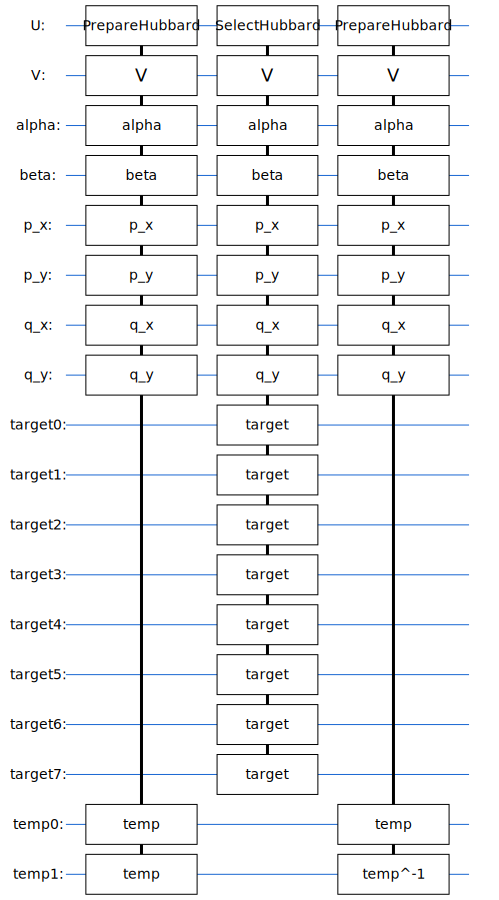

In [15]:
svg_circuit( circuit_decompose_multi(block_encoding.circuit,1) )

Demonstrating a different access strategy for the signal / selection registers.

<h5><b>4.2.3 Block Encoding: Comparative Scaling</b></h5>

We can compare the empirical resource overhead for `PauliLCU` and `FermiHubbardSquare` encodings at different problem scales, as specified by the dimensions of a square lattice.  This is accomplished by looping over the lattice dimensions 

<b>WARNING:</b> <i>The calculation block below can take roughly one hour to execute (specifically the PauliLCU segment).  Precomputed outputs are provided after the block.</i>

In [16]:

t_count_lcu                =   []
t_count_fh                 =   []
logical_qubits_lcu         =   []
logical_qubits_fh          =   []

problem_scale  = list([2**n for n in range(2,11)])

# problem_qubits = 2*np.array(problem_scale)**2

# for N in problem_scales:
#     model                =  getInstance('FermiHubbard',shape=(N,N), J=-1.0, U=4.0,cell=SquareLattice)
#     encoding_pauli_lcu   =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)
#     t_count_pauli_lcu.append( estimate_resources( encoding_pauli_lcu )['T'] )

#     estimate = estimate_resources( encoding_pauli_lcu )

#     t_count_lcu.append( estimate['T'] )
#     logical_qubits_lcu.append( estimate['LogicalQubits'] )

# for N in problem_scale:
    
#     model                           =  getInstance('FermiHubbard',shape=(N,N), J=-1.0, U=4.0,cell=SquareLattice)
#     encoding_fermi_hubbard          =  getEncoding(VALID_ENCODINGS.FermiHubbardSquare)(model)

#     estimate = estimate_resources( encoding_fermi_hubbard )

#     t_count_fh.append( estimate['T'] )
#     logical_qubits_fh.append( estimate['LogicalQubits'] )

<b>Todo:</b> Precompute PauliLCU data or just drop this part.

In [17]:
# problem_scales_lcu  =  np.array([4, 8, 16, 32, 64, 128])
# problem_qubits_lcu  =  np.array([   32,   128,   512,  2048,  8192, 32768])
# t_count_pauli_lcu   =  np.array([4892, 6860, 23900, 79870, 289064, 1102098])

In [18]:

problem_scale_fh  = [4, 8, 16, 32, 64, 128, 256]
problem_qubits_fh = [   32,   128,   512,  2048,  8192, 32768, 131072]
logical_qubits_fh = [46, 146, 534, 2074, 8222, 32802, 131110]
t_count_fh        = [1592, 2636, 6600, 22094, 83648, 329552, 1312736]

The optimized Fermi-Hubbard encoding should have a T-count that scales asymptotically as $O(N)$ and a requirement of $N+5 \log N$  logical qubits.  we verify this by fitting our scaling data:

In [19]:
## Add terms to fit beyond leading.
##

func_t_count_fh                      =   lambda N,a,b : a + b*N

func_logical_qubits_fh               =   lambda N,a,b : N + b*np.log(N)
fit_params_t_count_fh, conv          =   curve_fit(func_t_count_fh, problem_qubits_fh, t_count_fh)
fit_params_logical_qubits_fh, conv   =   curve_fit(func_logical_qubits_fh, problem_qubits_fh, logical_qubits_fh)

fit_func_t_count_fh                  =   lambda N : func_t_count_fh(N,*fit_params_t_count_fh)
fit_func_logical_qubits_fh           =   lambda N : func_logical_qubits_fh(N,*fit_params_logical_qubits_fh)

/var/folders/zq/bhhqxh310pz02jflnrvcc_1c0000gn/T/ipykernel_68726/1878076899.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params_logical_qubits_fh, conv   =   curve_fit(func_logical_qubits_fh, problem_qubits_fh, logical_qubits_fh)


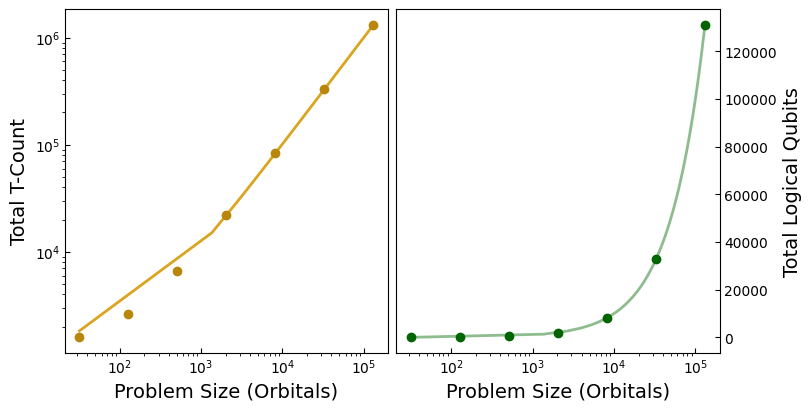

In [20]:
N_domain    =  np.linspace(problem_qubits_fh[0],problem_qubits_fh[-1], 100)

fig,ax = plt.subplots(1, 2, sharex=True,layout='constrained', figsize=(8, 4))


ax[0].loglog(N_domain, fit_func_t_count_fh(N_domain),linewidth=2,color='goldenrod')
#ax[0].plot(problem_qubits_lcu,t_count_lcu,'o',color='darkgoldenrod')

ax[0].loglog(problem_qubits_fh,t_count_fh,'o',color='darkgoldenrod')
ax[0].tick_params(direction="in")
ax[0].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[0].set_ylabel('Total T-Count',fontsize=14);

ax[1].plot(N_domain, fit_func_logical_qubits_fh(N_domain),linewidth=2,color='darkseagreen')
ax[1].plot(problem_qubits_fh,logical_qubits_fh,'o',color='darkgreen')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(direction="in")
ax[1].set_xlabel('Problem Size (Orbitals)',fontsize=14);
ax[1].set_ylabel('Total Logical Qubits',fontsize=14);


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new qualtran operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [21]:

model  =  getInstance('FermiHubbard',shape=(8,8), J=-1.0, U=4.0,cell=SquareLattice)
block_encoding = getEncoding(VALID_ENCODINGS.FermiHubbardSquare)(model)

for ctr,line in enumerate(openqasm(block_encoding.circuit,rotation_allowed=False)):
    if ctr < 100:
        print(line)

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [gancilla_c(0), gancilla_c(1), gancilla_c(2), gancilla_c(3), gancilla_c(4), gancilla_c(5), gancilla_c(6), U, V, add_ancilla0, add_ancilla1, add_ancilla2, alpha, beta, p_x0, p_x1, p_x2, p_y0, p_y1, p_y2, q_x0, q_x1, q_x2, q_y0, q_y1, q_y2, target0, target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20, target21, target22, target23, target24, target25, target26, target27, target28, target29, target30, target31, target32, target33, target34, target35, target36, target37, target38, target39, target40, target41, target42, target43, target44, target45, target46, target47, target48, target49, target50, target51, target52, target53, target54, target55, target56, target57, target58, target59, target60, target61, target62, target63, target64, target65, target66, targ